# Numerical Experiments - 5-bus case


## Set up

In [33]:
import numpy as np
import pandas as pd
from math import ceil
from itertools import product
import lropt
from utils import plot_iters, plot_coverage_all
import cvxpy as cp
from cvxpylayers.torch import CvxpyLayer
import torch
import scipy as sc

# from tqdm.notebook import tqdm, trange
from tqdm import tqdm, trange

import pickle

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.patches import Ellipse
from matplotlib.patches import Rectangle
from matplotlib.patches import Patch
import matplotlib.transforms as transforms
%matplotlib inline

import torch

DTYPE = torch.double
SEED = 42

# experiment default settings
N_DATA = 1000
MAX_EPOCH = 100
TEST_PERC = 0.25
CORR = 0.5

### Power system data

In [34]:
# parameters of matpower case 5

d = np.array([0.0, 3.0, 3.0, 4.0, 0.0])
pmax = np.array([0.4, 1.7, 5.2, 2.0, 6.0])
pmin = np.zeros(len(pmax))
smax = np.array([4.0, 1.9, 2.2, 1.0, 1.0, 2.4])
ptdf_str  = '-0.193917 0.475895   0.348989  0.0  -0.159538;'
ptdf_str += '-0.437588  -0.258343  -0.189451  0.0  -0.36001;'
ptdf_str += '-0.368495  -0.217552  -0.159538  0.0   0.519548;'
ptdf_str += '-0.193917  -0.524105   0.348989  0.0  -0.159538;'
ptdf_str += '-0.193917  -0.524105  -0.651011  0.0  -0.159538;'
ptdf_str += '0.368495   0.217552   0.159538  0.0   0.48045'
ptdf = np.matrix(ptdf_str)
cE = np.array([14.0, 15.0, 30.0, 40.0, 10.0]) # linear cost
cE_quad = np.sqrt(cE * 0.1) # quadratic cost
cR = np.array([80., 80., 15., 30., 80.])
basemva = 100
genloc = np.array([1, 1, 3, 4, 5]) -1
windloc = np.array([3, 5]) - 1  # standard wind farm location
# windloc = np.array([3, 2]) - 1  # configuration B
w = np.array([1.0, 1.5])
w_cap = np.array([2.0, 3.0])
G = len(genloc)
D = len(windloc)
L = ptdf.shape[0]
B = ptdf.shape[1]
gen2bus = np.zeros((B,G))
for g, bus in enumerate(genloc):
    gen2bus[bus, g] = 1
wind2bus = np.zeros((B,D))
for u, bus in enumerate(windloc):
    wind2bus[bus, u] = 1

### Operational model

In [35]:

def box_robust_dcopf_problem_param(mu_init, sigma_init, demand, wind, allow_slack=False, quadratic_cost=False, gamma=0):


    # some settings
    A_base = 10
    slack_base = 10
    obj_base = basemva/10
    
    FR = 0.8 # reduction of line capacity
    
    # define mean and uncertainty of wind power injections as parameters
    mu = cp.Parameter(D, value=mu_init, name="mu")
    sigma = cp.Parameter(D, value=sigma_init, name="sigma")
    
     # define load as a parameter
    d = cp.Parameter(B, value=demand, name="demand")
    w = cp.Parameter(D, value=wind, name="wind")
        
    # main variables
    p  = cp.Variable(G, pos=True, name="p")
    rp = cp.Variable(G, pos=True, name="rp")
    rm = cp.Variable(G, pos=True, name="rm")
    A  = cp.Variable((G,D), pos=True, name="A")
    fRAMp = cp.Variable(L, pos=True, name="fRAMp")
    fRAMm = cp.Variable(L, pos=True, name="fRAMm")

    # aux. variables for robust constraints
    z = cp.Variable((2*G + 2*L,D), name="z")
    
    # aux. variables to ensure feasibility
    if allow_slack:
        slack = cp.Variable(2*G + 2*L, pos=True, name="slack")
    
    # basic det constraints
    flow = ptdf @ ((gen2bus @ p) + (wind2bus @ w) - d)
    consts = [
        cp.sum(p) + cp.sum(w) == cp.sum(d),
        p + rp <= pmax,
        p - rm >= pmin, 
        A.T @ np.ones(G) == np.ones(D)*A_base,
         flow + fRAMp == smax * FR,
        -flow + fRAMm == smax * FR
    ]

    # box support constraints
    for g in range(G):
        if allow_slack:
            consts.append((mu.T @ (-A[g,:]/A_base)) + (sigma.T @ A[g,:]/A_base) <= rp[g] + slack[g]/slack_base)
        else:
            consts.append((mu.T @ (-A[g,:]/A_base)) + (sigma.T @ A[g,:]/A_base) <= rp[g])
        if allow_slack:
            consts.append((mu.T @ (A[g,:]/A_base)) + (sigma.T @  A[g,:]/A_base) <= rm[g] + slack[g+G]/slack_base)
        else:
            consts.append((mu.T @ (A[g,:]/A_base)) + (sigma.T @  A[g,:]/A_base) <= rm[g])
    for l in range(L):
        Bl = cp.reshape(ptdf[l,:] @ (wind2bus - (gen2bus @ A/A_base)), D)
        # Bl = (ptdf[l,:] @ (wind2bus - (gen2bus @ A))).T
        if allow_slack:
            consts.append(mu.T @ Bl + (sigma.T @ z[l,:]) <= fRAMp[l] + slack[2*G+l]/slack_base)
        else:
            consts.append(mu.T @ Bl + (sigma.T @ z[l,:]) <= fRAMp[l])
        consts.append(z[l,:] >= Bl)
        consts.append(z[l,:] >= -Bl)
        if allow_slack:
            consts.append(mu.T @ -Bl + (sigma.T @ z[L+l,:]) <= fRAMm[l] + slack[2*G+L+l]/slack_base)   
        else:
            consts.append(mu.T @ -Bl + (sigma.T @ z[L+l,:]) <= fRAMm[l])
        consts.append(z[L+l,:] >= -Bl)
        consts.append(z[L+l,:] >= Bl)

    # objective
    cost_E = (cE.T @ p)
    if quadratic_cost:
        cost_E_quad = cp.sum_squares(cp.multiply(cE_quad, p))
    else:
        cost_E_quad = 0                         
    cost_R = (cR.T @ (rp + rm))
    objective = cost_E + cost_E_quad + cost_R
    
    if allow_slack:
        thevars = [p, rp, rm, A, fRAMp, fRAMm, z, slack]
    else:
        thevars = [p, rp, rm, A, fRAMp, fRAMm, z]
    x = cp.hstack([v.flatten() for v in thevars])
    regularization = gamma * cp.sum_squares(x)
    objective += regularization
    
    if allow_slack:
        penalty_slack = cp.sum(slack) * obj_base * 1e3
        objective += penalty_slack
    
    theprob = cp.Problem(cp.Minimize(objective), consts)
    
    return theprob, thevars, [d, w, mu, sigma], consts

## LROPT model

In [36]:

def box_robust_dcopf_problem_param_l_max(mu_init, sigma_init, demand, wind, allow_slack=False, quadratic_cost=False, gamma=0, train = False, traindat = None, inita=None, initb=None, initeps=1, p=np.inf, MRO = False, K=1, wind2 = None, wind3 = None):

    
    # some settings
    A_base = 1
    slack_base = 1
    obj_base = basemva/1
    
    FR = 0.8 # reduction of line capacity

    # define uncertain parameter and support 
    # Dsupp = np.vstack([np.eye(D),-np.eye(D)])
    # dsupp = np.hstack([np.array(mu_init) + np.array(sigma_init), -np.array(mu_init) + np.array(sigma_init)])
    # u = lropt.UncertainParameter(D,
    #                             uncertainty_set=lropt.Ellipsoidal(p=np.inf,
    #                                                         a=np.eye(D), b=-mu_init, rho = np.max(sigma_init), c = Dsupp, d = dsupp))
    if train: 
        u = lropt.UncertainParameter(D,
                                    uncertainty_set=lropt.Ellipsoidal(p=p,a=np.array(sigma_init), b=mu_init,
                                                                data=traindat))
        
        # define mean and uncertainty of wind power injections as parameters
        # mu = cp.Parameter(D, value=mu_init, name="mu")
        # sigma = cp.Parameter(D, value=sigma_init, name="sigma")
        
        # define load as a parameter
        d = lropt.Parameter(B, data=demand, name="demand")
        w = lropt.Parameter(D, data=wind, name="wind")
        wind2 = lropt.Parameter(D, data=wind2)
        wind3 = lropt.Parameter(D, data=wind3)
    else: 
        u = lropt.UncertainParameter(D,
                                    uncertainty_set=lropt.Ellipsoidal(p=p,
                                                                a=inita, b=initb, rho = 1))
        d = cp.Parameter(B, value=demand, name="demand")
        w = cp.Parameter(D, value=wind, name="wind")
    if inita is not None:
        u = lropt.UncertainParameter(D,
                                    uncertainty_set=lropt.Ellipsoidal(p=p,
                                                                a=inita, b=initb, rho = initeps))
        
        # define mean and uncertainty of wind power injections as parameters
        # mu = cp.Parameter(D, value=mu_init, name="mu")
        # sigma = cp.Parameter(D, value=sigma_init, name="sigma")
        
        # define load as a parameter
    if MRO:
        u = lropt.UncertainParameter(D,
                                    uncertainty_set=lropt.MRO(K=K, p=p,
                                                                 rho = initeps, train = train, data=traindat))
        
        
    # main variables
    p  = cp.Variable(G, pos=True, name="p")
    rp = cp.Variable(G, pos=True, name="rp")
    rm = cp.Variable(G, pos=True, name="rm")
    A  = cp.Variable((G,D), pos=True, name="A")
    fRAMp = cp.Variable(L, pos=True, name="fRAMp")
    fRAMm = cp.Variable(L, pos=True, name="fRAMm")

    # aux. variables for robust constraints
    # z = cp.Variable((2*G + 2*L,D), name="z")
    
    # aux. variables to ensure feasibility
    if allow_slack:
        slack = cp.Variable(2*G + 2*L, pos=True, name="slack")
    
    # basic det constraints
    flow = ptdf @ ((gen2bus @ p) + (wind2bus @ w) - d)
    consts = [
        cp.sum(p) + cp.sum(w) == cp.sum(d),
        p + rp <= pmax,
        p - rm >= pmin, 
        A.T @ np.ones(G) == np.ones(D)*A_base,
         flow + fRAMp == smax * FR,
        -flow + fRAMm == smax * FR
    ]
    maxcons = []
    # box support constraints
    for g in range(G):
        if allow_slack:
            maxcons.append((-A[g,:]/A_base)@u - rp[g] - slack[g]/slack_base )
        else:
            maxcons.append((-A[g,:]/A_base)@u - rp[g])
        if allow_slack:
            maxcons.append(((A[g,:]/A_base))@u- rm[g] - slack[g+G]/slack_base)
        else:
            maxcons.append(((A[g,:]/A_base))@u - rm[g])
    for l in range(L):
        Bl = cp.reshape(ptdf[l,:] @ (wind2bus - (gen2bus @ A/A_base)), D)
        if allow_slack:
            maxcons.append(Bl@u- fRAMp[l] - slack[2*G+l]/slack_base)
        else:
            maxcons.append(Bl@u - fRAMp[l])
        if allow_slack:
            maxcons.append(-Bl@u - fRAMm[l] - slack[2*G+L+l]/slack_base) 
        else:
            maxcons.append(-Bl@u -  fRAMm[l])
    
    consts.append(cp.maximum(*maxcons)<=0)
    if wind2 is not None: 
        consts += [wind2 >= -10, wind3 >= -10]
    # objective
    cost_E = (cE.T @ p)
    if quadratic_cost:
        cost_E_quad = cp.sum_squares(cp.multiply(cE_quad, p))
    else:
        cost_E_quad = 0                         
    cost_R = (cR.T @ (rp + rm))
    objective = cost_E + cost_E_quad + cost_R
    
    if allow_slack:
        thevars = [p, rp, rm, A, fRAMp, fRAMm,slack]
    else:
        thevars = [p, rp, rm, A, fRAMp, fRAMm]
    x = cp.hstack([v.flatten() for v in thevars])
    regularization = gamma * cp.sum_squares(x)
    objective += regularization
    
    if allow_slack:
        penalty_slack = cp.sum(slack) * obj_base * 1e3
        objective += penalty_slack
    
    theprob = lropt.RobustProblem(cp.Minimize(objective), consts, eval_exp = objective)
    
    return theprob, thevars, [d, w], consts

### Error data

In [37]:
# can change this to be more complex. include correlations. 
# y can also include other information not in the model. 
# u is the predicted 
def create_historical_data(w_fcst, N=1000, SEED=42, metadata=False, corr=0.1, rel_sigma=[0.15, 0.15]):
    mu = np.zeros(D)
    rel_sigma = np.array(rel_sigma)
    correlation = np.matrix([[1.0, corr],[corr, 1.0]])
    sigma = w_fcst * rel_sigma
    Sigma = np.diag(sigma)*correlation*np.diag(sigma)
    # sample
    # np.random.seed(seed=SEED)
    hist_data = np.random.multivariate_normal(mu, Sigma, size=N)
    # truncate
    for j in range(D):
        hist_data[(hist_data[:,j] >= w_cap[j] - w_fcst[j]),j] = w_cap[j] - w_fcst[j]
        hist_data[(hist_data[:,j] <= -w_fcst[j]),j] = -w_fcst[j]
    if metadata:
        return hist_data, mu, Sigma
    else:
        return hist_data

In [38]:

TEST_PERC = 0.25
CORR = 0.5

# reset randomness
np.random.seed(seed=10)

# some other settings
d_range = [0.5, 1.1]
w_range = [0.5, 1.1]

# define bins
nbins = 10
bins = [np.linspace(w_range[0]*w[i], w_range[1]*w[i], nbins+1) for i in range(D)]

# create a large set of forecast errors from different wind scenarios
N_samples = 1250
train_errors_in_bins = [[[] for bi in range(nbins+3)] for i in range(D)]
all_errors = []
for i in trange(N_samples):
    d_scenario_np = np.random.uniform(*d_range, B) * d
    w_scenario_np = np.random.uniform(*w_range, D) * w
    cur_data = create_historical_data(w_scenario_np, N=1, corr=CORR)[0]
    for i in range(D):
        cur_bin = np.digitize(w_scenario_np[i], bins[i])
        train_errors_in_bins[i][cur_bin].append(cur_data[i])
    all_errors.append(cur_data)
all_errors = np.vstack(all_errors)

train, test = train_test_split(all_errors, test_size=int(all_errors.shape[0]*TEST_PERC), random_state=SEED)

train_data = torch.tensor(train, dtype=DTYPE)
test_data = torch.tensor(test, dtype=DTYPE)

# init based on stdv
mu_init = np.mean(train, axis=0)
sigma_init =np.std(train, axis=0)/2

# percentile-based set paramters
perc= 10 # in percent
percupper = np.percentile(train, 100-perc, axis=0)
perclower = np.percentile(train, perc, axis=0)
mu_base_perc = (percupper + perclower) / 2
sigma_base_perc = mu_init + ((percupper - perclower) / 2)

  0%|          | 0/1250 [00:00<?, ?it/s]

100%|██████████| 1250/1250 [00:00<00:00, 5644.24it/s]


### Real Data

In [39]:
station1 = pd.read_csv("wind_load_data/station1.csv")
station2 = pd.read_csv("wind_load_data/station2.csv")
loads = pd.read_csv("wind_load_data/load_3buses_NYISO-2018.csv")

In [40]:
data = {}
data[1] = np.vstack([np.array(station1["hour_ahead_forecast_error"]),np.array(station2["hour_ahead_forecast_error"])]).T
data[4] = np.vstack([np.array(station1["4_hour_ahead_forecast_error"]),np.array(station2["4_hour_ahead_forecast_error"])]).T
data[6] = np.vstack([np.array(station1["6_hour_ahead_forecast_error"]),np.array(station2["6_hour_ahead_forecast_error"])]).T

In [41]:
for dat in [train,data[1][:5000],data[4][:5000],data[6][:5000]]:
  print(np.min(dat),np.max(dat), np.mean(dat), np.std(dat))

-0.6489225134353045 0.5441159943812579 -0.001763045064536129 0.15456118067919491
-1.0 1.0 -0.00011842696609409025 0.21523476073322034
-0.8584534585475921 0.7552648442132134 -0.0039013733514871233 0.20633890744021247
-0.8508576333522796 0.8039786338806153 -0.0046106630517607355 0.22209197641311215


In [42]:
w_data = {}
w_data[1] = np.vstack([np.array(station1["hour_ahead_power_norm"]),np.array(station2["hour_ahead_power_norm"])]).T
w_data[4] = np.vstack([np.array(station1["4_hour_ahead_power_norm"]),np.array(station2["4_hour_ahead_power_norm"])]).T
w_data[6] = np.vstack([np.array(station1["6_hour_ahead_power_norm"]),np.array(station2["6_hour_ahead_power_norm"])]).T

In [43]:
num = loads["d2"].shape[0]
d_data = np.vstack([np.zeros(num),loads["d2"],loads["d3"],loads["d4"],np.zeros(num)]).T

### Model test

In [44]:
prob, _, theparams, _ = box_robust_dcopf_problem_param(mu_init, sigma_init, d, w, allow_slack=False, quadratic_cost=True)
prob.solve(solver="CLARABEL")

194.9005595103984

## LROPT model test

In [45]:
prob_lroptmax, thevarslroptmax, theparamslroptmax, _ = box_robust_dcopf_problem_param_l_max(mu_init, sigma_init, d, w, allow_slack=False, quadratic_cost=True, inita = np.diag(np.array(sigma_init)),initb=mu_init)
prob_lroptmax.solve(solver="CLARABEL")

194.9005599689989

In [46]:
# test feasibility for a few random scenarios
#0.5-1.1
# can change range 0.8
d_range = [0.5, 1.1]
w_range = [0.5, 1.1]
d_scenario = np.random.uniform(*d_range, B) * d
w_scenario = np.random.uniform(*w_range, D) * w

theparams[0].value = d_scenario
theparams[1].value = w_scenario
prob.solve(solver="CLARABEL")
# print(prob.status)
print(f'Objective value:  {prob.objective.value:.4f}') 

Objective value:  105.5284


In [47]:
theparamslroptmax[0].value = d_scenario
theparamslroptmax[1].value = w_scenario
prob_lroptmax.solve(solver="CLARABEL")
print(f'Objective value:  {prob_lroptmax.objective.value:.4f}') 

Objective value:  105.5284


## LROPT Training

In [48]:
# Generate a batch of scenarios for d and w
def gen_dw_data(num, d,w, seed=SEED):
    d_dat = d 
    w_dat = w
    for i in range(num-1):
        d_scenario = np.random.uniform(*d_range, B) * d
        w_scenario = np.random.uniform(*w_range, D) * w
        d_dat = np.vstack([d_dat,d_scenario])
        w_dat = np.vstack([w_dat, w_scenario])
    return d_dat, w_dat
N_samples = 1000
# d_dat, w_dat = gen_dw_data(int(N_samples*(1-TEST_PERC)),d,w)
d_dat, w_dat = gen_dw_data(int(N_samples),d,w)
init_aval = np.diag(np.array(sigma_init))
init_bval =mu_init

In [78]:
concat_cur_data = np.hstack([data[1],w_data[6],w_data[4], w_data[1]])[10000:11001]
# random_inds = np.random.choice(concat_cur_data.shape[0],1001,False)
# concat_cur_data = concat_cur_data[random_inds]
train,test = train_test_split(concat_cur_data, test_size=1, random_state=SEED)
cur_data = train[:,:2]
# cur_data = np.multiply(w_cap,cur_data)
mu_init = np.mean(cur_data, axis = 0)
sigma_init = sc.linalg.sqrtm(np.cov(cur_data.T))
cur_w_dat6 = train[:,2:4]
cur_w_dat4 = train[:,4:6]
cur_w_dat1 = train[:,6:]
# cur_w_dat1 = np.multiply(w_cap,cur_w_dat1)
# cur_w_dat4 = np.multiply(w_cap,cur_w_dat4)
# cur_w_dat6 = np.multiply(w_cap,cur_w_dat6)
d_datnew = np.multiply(d,d_data+0.1)
random_inds = np.random.choice(d_datnew.shape[0],1000,False)
d_datnew = d_datnew[random_inds]

In [79]:
prob_lropt, thevarslropt, theparamslropt, _ = box_robust_dcopf_problem_param_l_max(mu_init, sigma_init, d_datnew[:2000], cur_w_dat1[:2000], allow_slack=False, quadratic_cost=True, train=True, traindat=cur_data[:2000], p=2, MRO=False, K=5, initeps=0.1, wind2 = cur_w_dat4[:2000], wind3 = cur_w_dat6[:2000])
init_aval = sigma_init
init_bval = mu_init
# init_aval = np.eye(2)
# init_bval = np.zeros(2)
np.random.seed(15)
# init_avaln = 0.5*(0.8*init_aval -0.2*np.random.rand(2,2)+0.2*np.eye(2))
# init_avaln = 0.2*np.random.rand(2,2)

In [80]:
result = prob_lropt.train(init_eps = 1.0, lr = 0.0001,num_iter=1000, optimizer = "SGD", seed = SEED+1, init_A =init_aval, init_b = init_bval, init_lam = 100, init_mu = 500, mu_multiplier=1.01, init_alpha = -0.0, test_percentage = TEST_PERC, save_history = True, lr_step_size = 100, lr_gamma = 0.5, position = False, random_init = False, num_random_init=2, parallel = False, kappa=0., eta=0.3, contextual=True)

/Users/irina.wang/anaconda3/envs/lropt_s/lib/python3.11/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/anaconda3/envs/lropt_s/lib/python3.11/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
 

In [81]:
result_mvar = prob_lropt.grid(epslst = np.linspace(0.1,3, 10), init_A = init_aval, init_b = init_bval, seed = SEED, init_alpha = 0., test_percentage = TEST_PERC)
dfgrid = result_mvar.df

/Users/irina.wang/anaconda3/envs/lropt_s/lib/python3.11/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/anaconda3/envs/lropt_s/lib/python3.11/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
 

In [82]:
result_reshape = prob_lropt.grid(init_eps= result.eps, epslst = np.linspace(0.1,3, 10), init_A =result.A, init_b = result.b, seed = SEED, init_alpha = 0., test_percentage = 
TEST_PERC, contextual = True, linear = result._linear)
dfgrid2 = result_reshape.df
# result_a = prob_lropt.grid(epslst = [4,5], init_A = result.A, init_b = result.b, seed = SEED, init_alpha = 0., test_percentage = 0.01)

/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/robust_problem.py:318: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_tch = torch.tensor(a_tch, requires_grad=False)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/robust_problem.py:319: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b_tch = torch.tensor(b_tch, requires_grad=False)
/Users/irina.wang/anaconda3/envs/lropt_s/lib/python3.11/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadp

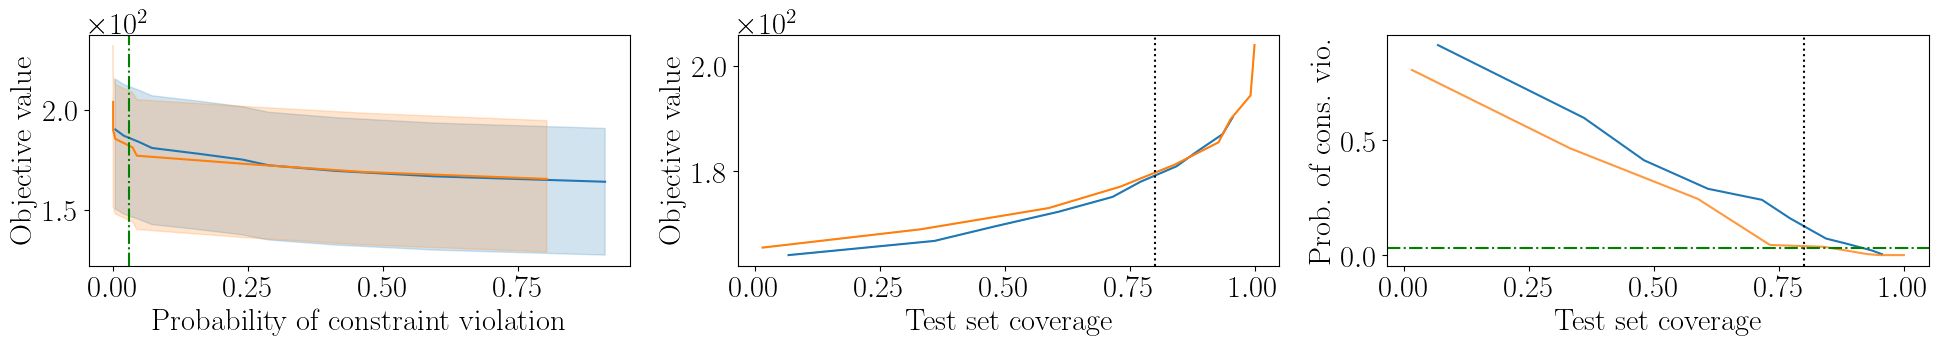

In [ ]:
plot_coverage_all(dfgrid,dfgrid2,None, "energy",ind_1=(0,10),ind_2=(0,10), logscale = False)

In [ ]:
def calc_obj(df,rangee,epsind):
  obj_val = 0
  for ind in rangee:
    (p_v,rp_v,rm_v,A_v,fRAMp_v,fRAMm_v) = [df["var_values"][epsind][j][ind] for j in range(6)]
    x = cp.hstack([v.detach().numpy().flatten() for v in [p_v,rp_v,rm_v,A_v,fRAMp_v,fRAMm_v]])
    obj_val += ((cE.T @ p_v.detach().numpy()) + cp.sum_squares(cp.multiply(cE_quad, p_v.detach().numpy())) + (cR.T @ (rp_v.detach().numpy() + rm_v.detach().numpy())) + 0 * cp.sum_squares(x)).value
  obj_val = obj_val/len(rangee)
  return obj_val
rangee = range(15,16)
print("mv obj:", calc_obj(dfgrid,rangee,5))
print("re obj:", calc_obj(dfgrid2,rangee,4))

mv obj: 109.97415863325202
re obj: 111.66848122647524


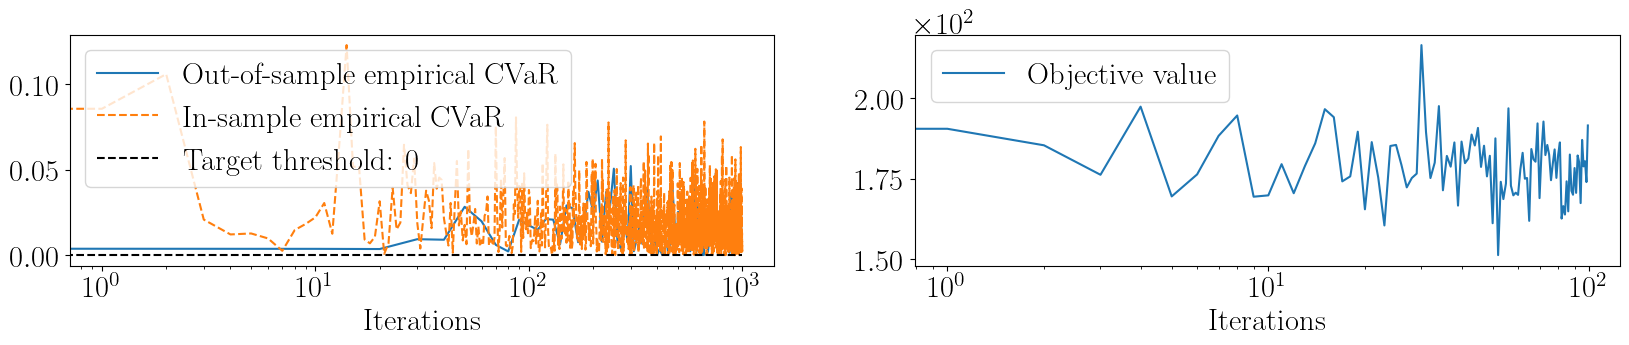

In [ ]:
plot_iters(result.df, result.df_test,"energy", logscale = True, steps = 1000)

In [ ]:
# plt.figure(figsize=(8,2))
# plt.plot(np.arange(result.df.shape[0]),np.hstack(result.df['lam_list']), label = r"$\lambda$")
# plt.plot(np.arange(result.df.shape[0]),result.df['mu'], label = r"$\mu$")
# plt.legend()
# plt.xlabel("Iterations")
# plt.ylabel("Values")
# # plt.yscale("log")

In [ ]:
prob_list = np.array([0.,0.01,0.05,0.1])
eps_list = np.linspace(0.1,6, 10)
# prob_list = np.linspace(0,0.5,10)
inds_standard = []
inds_reshaped = []
for i in prob_list:
    inds_standard.append(np.absolute(np.mean(np.vstack(dfgrid['Avg_prob_test']),axis = 1)-i).argmin())
    inds_reshaped.append(np.absolute(np.mean(np.vstack(dfgrid2['Avg_prob_test'][:5]),axis = 1)-i).argmin())
st_eps = eps_list[inds_standard[0]]
re_eps = eps_list[inds_reshaped[0]]
st_eps, re_eps
# A_fin = initn
# b_fin = init_bvaln

(6.0, 2.7222222222222223)

In [ ]:
train = cur_data
K = 10
Amat = result._a_history[-1]*result.eps
bvec = result._b_history[-1]
eps_fin = result.eps
num_p = 50
offset = 0.2
x_min, x_max = np.min(train[:,0]) - offset, np.max(train[:,0]) + offset
y_min, y_max = np.min(train[:,1]) - offset, np.max(train[:,1]) + offset
X = np.linspace(x_min,x_max,num_p)
Y = np.linspace(y_min,y_max,num_p)
x,y = np.meshgrid(X,Y)
# Z values as a matrix
fin_set = {}
init_set = {}
for ind in range(4):
    fin_set[ind] = {}
    init_set[ind] = {}
    for k_ind in range(K):
        fin_set[ind][k_ind] = np.zeros((num_p,num_p))
        init_set[ind][k_ind] = np.zeros((num_p,num_p))
g_level_learned = {}
g_level_base = {}
for ind in range(4):
    g_level_learned[ind] = {}
    g_level_base[ind] = {}
    for scene in range(10):
        g_level_learned[ind][scene] = np.zeros((num_p,num_p))
        g_level_base[ind][scene] = np.zeros((num_p,num_p))
# init_set = np.zeros((num_p,num_p))
    # Populate Z Values (a 7x7 matrix) - For a circle x^2+y^2=z
    for i in range(num_p):
        for j in range(num_p):
            u_vec = [x[i,j], y[i,j]]
            for k_ind in range(K):
                fin_set[ind][k_ind][i,j] = np.linalg.norm((1/eps_list[inds_reshaped[ind]])*(Amat[k_ind].T@np.linalg.inv(Amat[k_ind]@Amat[k_ind].T))@(u_vec - bvec[k_ind]))
                # np.linalg.norm((1/eps_list[inds_reshaped[ind]])*A_fin[k_ind*n:(k_ind+1)*n, 0:n]@ u_vec + (1/eps_list[inds_reshaped[ind]])*b_fin)
                # fin_set[ind][k_ind][i,j] = np.linalg.norm((1/inds_reshaped[ind])*A_fin[k_ind*n:(k_ind+1)*n, 0:n]@ u_vec + (1/inds_reshaped[ind])*b_fin)

            for k_ind in range(K):
                init_set[ind][k_ind][i,j] = np.linalg.norm((1/eps_list[inds_standard[ind]])*(init_aval.T@np.linalg.inv(init_aval@init_aval.T))@(u_vec  - init_bval))

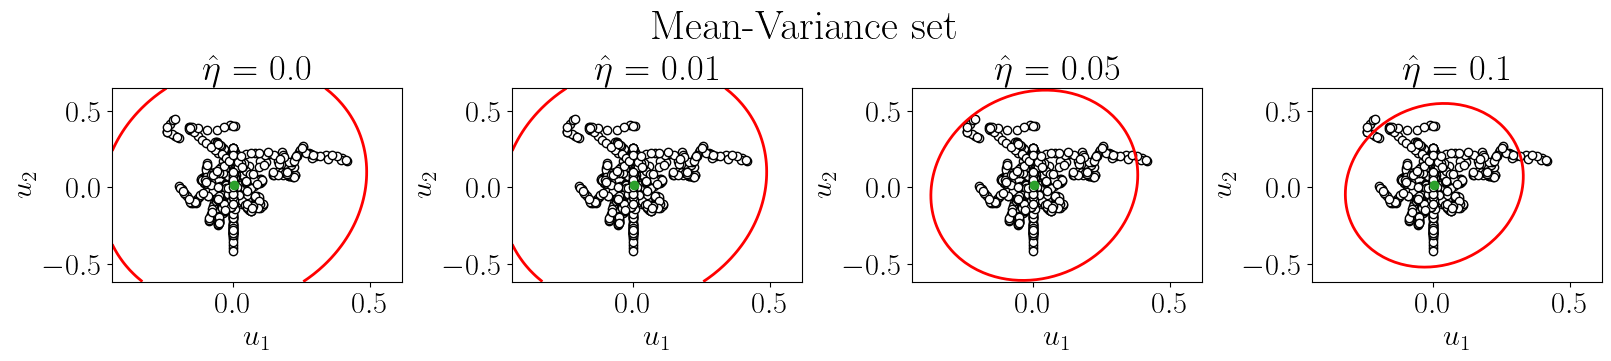

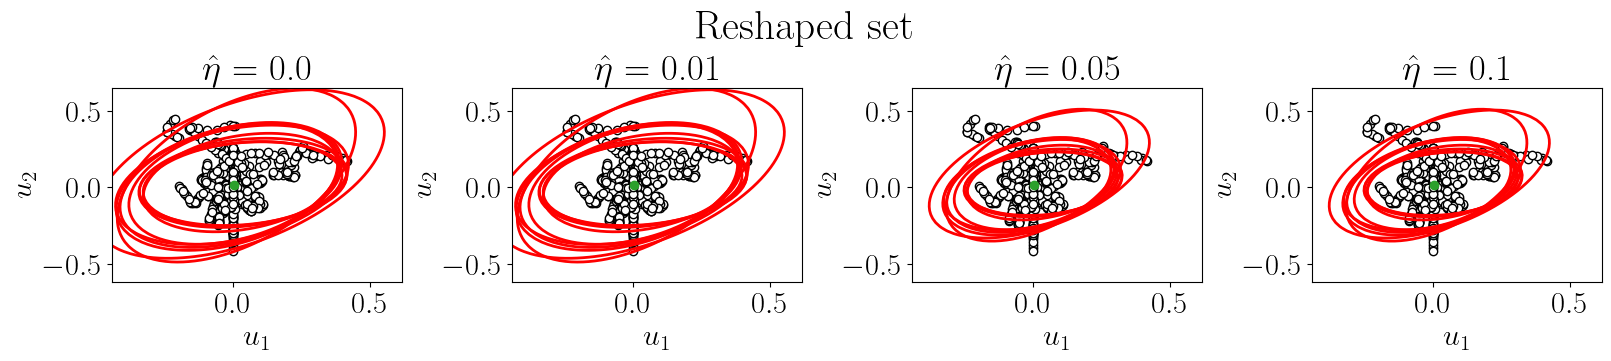

In [ ]:

def plot_contours_line(x,y,set, g_level,prob_list, num_scenarios,train, title, standard = True, K=1):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 3.5), constrained_layout= True)
    ax_lst = [ax1, ax2, ax3, ax4]
    np.random.seed(0)
    newtrain = np.random.choice(train.shape[0],size=train.shape[0],replace=False)
    cur_ind = 0
    for axis in ax_lst:
        axis.set_title(r'$\hat{\eta}$' + ' = {}'.format(prob_list[cur_ind]))
        axis.set_xlabel(r"$u_1$")
        axis.set_ylabel(r"$u_2$")
        # for scene in range(num_scenarios):
        #     axis.contour(x,y,g_level[cur_ind][scene],[0], colors = ["tab:purple"],alpha = 1,linestyles = ["-"])
        axis.scatter(train[:,0][newtrain],train[:,1][newtrain], color = "white",edgecolor = "black")
        axis.scatter(np.mean(train,axis= 0)[0], np.mean(train,axis= 0)[1],color = ["tab:green"])
        for k_ind in range(K):
            axis.contour(x,y,set[cur_ind][k_ind], [1], colors = ["red"],linewidths = [2])
        cur_ind +=1
    if standard:
        post = "Mean-Variance"
    else:
        post = "Reshaped"
    fig.suptitle(post+" set", fontsize = 30)
    plt.savefig(title+"_"+ post + ".pdf", bbox_inches='tight')
plot_contours_line(x,y,init_set, None,prob_list,10,cur_data, "energy_st",standard = True, K=1) 
plot_contours_line(x,y,fin_set, None,prob_list,10,cur_data, "energy_re",standard = False, K=10)

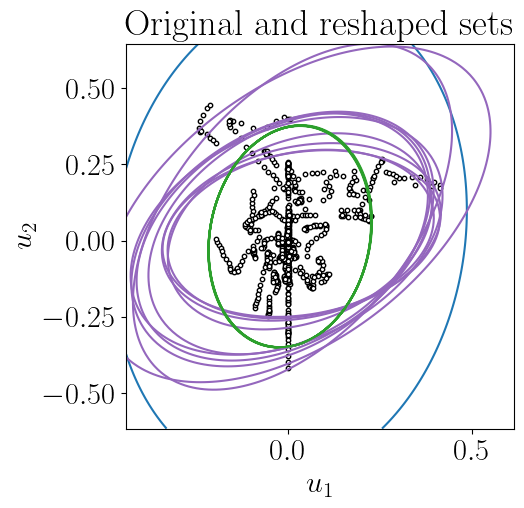

In [ ]:
offset = 0.2
x_min, x_max = np.min(train[:,0]) - offset, np.max(train[:,0]) + offset
y_min, y_max = np.min(train[:,1]) - offset, np.max(train[:,1]) + offset
n_points = 100
X = np.linspace(x_min,x_max,n_points)
Y = np.linspace(y_min,y_max,n_points)
x_mesh,y_mesh = np.meshgrid(X,Y)
A1_iters, b1_iters = result.uncset_iters
eps_iters = result._eps_history
def level_set(A_final, b_final, offset = 2, n = n_points, x_mesh = x_mesh, y_mesh = y_mesh, contextual = False):
    if not contextual:
        unc_level_set = np.zeros((n,n))
    else:
        unc_level_set = np.zeros((K,n,n))
    for i in range(n):
        for j in range(n):
            u_vec = [x_mesh[i,j], y_mesh[i,j]]
            for scene in range(K):
                if contextual:
                    unc_level_set[scene,i,j] = np.linalg.norm((A_final[scene].T@np.linalg.inv(A_final[scene]@A_final[scene].T)) @ (u_vec  - b_final[scene]))
                else:
                    unc_level_set[i,j] = np.linalg.norm((A_final.T@np.linalg.inv(A_final@A_final.T)) @ (u_vec  - b_final))

    return unc_level_set

unc_level_learned= level_set(A1_iters[-1]*re_eps*result.eps, b1_iters[-1], contextual = True)
unc_level = level_set(A1_iters[1]*re_eps, b1_iters[1], contextual = True)
unc_level_base = level_set(init_aval*st_eps, init_bval, contextual = False)

plt.figure(figsize=(5, 5))
plt.title("Original and reshaped sets")
# Set axis label for the contour plot
plt.xlabel(r"$u_1$")
plt.ylabel(r"$u_2$")

plt.contour(x_mesh,y_mesh,unc_level_base, [1], colors = ["tab:blue"]) #label = "MV Set"
for scene in range(10):
    plt.contour(x_mesh,y_mesh,unc_level_learned[scene,:,:], [1], colors = ["tab:purple"]) #, label = "Final Set"
    plt.contour(x_mesh,y_mesh,unc_level[scene,:,:], [1], colors = ["tab:green"]) #, label = "Initial Set"
plt.scatter(train[:,0],train[:,1], color = "white",edgecolors= "black", s = 10)
# plt.savefig("Reshaped_ctrs.pdf", bbox_inches='tight')
plt.show()

### Create Gif

In [ ]:
import os
import imageio

newpath = "gif_images/"
if not os.path.exists(newpath):
    os.makedirs(newpath)    
newpath = "gifs/"
if not os.path.exists(newpath):
    os.makedirs(newpath)   

filenames = []
eps_train = np.linspace(1,re_eps, 80)
# inds = np.hstack([np.arange(20,step=2), np.arange(22,400,step=5)])
inds = np.hstack([np.arange(1,1000,step=10),1000])
for i in range(len(inds)):
    ind = inds[i]
    unc_level = level_set(A1_iters[ind]*re_eps*eps_iters[ind], b1_iters[ind], contextual = True)
    # if i < 10:
    #     unc_level, g_level = level_set(A1_iters[i], b1_iters[i])
    # elif i < 20:
    #     unc_level, g_level = level_set(A1_iters[10+9*(i-10)], b1_iters[10+9*(i-10)])
    # else:
    #     unc_level, g_level = level_set(A1_iters[99]/eps_train[i-20], b1_iters[99]/eps_train[i-20])
    plt.figure(figsize=(5, 5))
    plt.title("Aug. Lag: {}".format(np.round(result.df["Lagrangian_val"].iloc[ind-1],3)))
    # Set axis label for the contour plot
    # plt.xlabel(r"$u_1$")
    # plt.ylabel(r"$u_2$")

    plt.contour(x_mesh,y_mesh,unc_level_base, [1], colors = ["tab:blue"]) #, label = "Initial Set"
    for scene in range(3):
        plt.contour(x_mesh,y_mesh,unc_level[scene,:,:], [1], colors = ["tab:red"]) # label = "trained Set"
        plt.contour(x_mesh,y_mesh,unc_level_learned[scene,:,:], [1], colors = ["tab:green"]) #, label = "Final Set"

    filename = f'gif_images/{i}.png'
    filenames.append(filename)

    plt.scatter(train[:,0],train[:,1], color = "white",edgecolors= "black", s = 10)
    plt.savefig(filename)
    plt.close()

with imageio.get_writer('gifs/energy1.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

/var/folders/yj/ns1g3ynx5sq0b0747kq8nz21t6q45w/T/ipykernel_2925/645307983.py:44: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [ ]:
j = 40
a_shape = (2,2)
b_shape = [2]
theta = result._linear(torch.tensor(np.hstack([d_dat[j:j+1],cur_w_dat6[j:j+1],cur_w_dat4[j:j+1],cur_w_dat1[j:j+1]])))
raw_a = theta[:,:a_shape[0]*a_shape[1]]
raw_b = theta[:,a_shape[0]*a_shape[1]:]
a_tch = raw_a.view(theta.shape[0],a_shape[0],a_shape[1]).detach().numpy()
b_tch = raw_b.view(theta.shape[0],b_shape[0]).detach().numpy()
prob_lropt, thevarslropt, theparamslropt, _ = box_robust_dcopf_problem_param_l_max(None, None, d_dat[j], cur_w_dat6[j], allow_slack=False, quadratic_cost=True,inita=a_tch[0], initb=b_tch[0], initeps=0.22, p=2)
prob_lropt.solve(solver=cp.CLARABEL)
prob_lropt2, thevarslropt, theparamslropt, _ = box_robust_dcopf_problem_param_l_max(mu_init, sigma_init, d_dat[j], cur_w_dat6[j], allow_slack=False, quadratic_cost=True,inita=init_aval, initb=init_bval, initeps=2.35, p=2 )
prob_lropt2.solve(solver=cp.CLARABEL)
print(prob_lropt.objective.value, prob_lropt2.objective.value)


256.71355903861223 280.23390235830254


In [ ]:
def plot_coverage_all(df_standard,df_reshape,dfs,title,ind_1 = (0,100), ind_2 = (0,100), logscale = True, legend = False, zoom = False):
    plt.rcParams.update({
    "text.usetex":True,

    "font.size":22,
    "font.family": "serif"
})
    beg1,end1 = ind_1
    beg2,end2 = ind_2

    fig, (ax, ax1,ax2) = plt.subplots(1, 3, figsize=(23, 3))
    
    ax.plot(np.mean(np.vstack(df_standard['Probability_violations_test']),axis = 1)[beg1:end1], df_standard['Test_val'][beg1:end1], color="tab:blue", label=r"Mean-Var set", marker = 'o')
    ax.fill(np.append(np.mean(np.vstack(df_standard['Probability_violations_test']),axis = 1)[beg1:end1],np.mean(np.vstack(df_standard['Probability_violations_test']),axis = 1)[beg1:end1][::-1]), np.append(df_standard['Lower_test'][beg1:end1],df_standard['Upper_test'][beg1:end1][::-1]), color="tab:blue", alpha=0.2)

    ax.plot(np.mean(np.vstack(df_reshape['Probability_violations_test']),axis = 1)[beg2:end2], df_reshape['Test_val'][beg2:end2], color="tab:orange", label=r"Reshaped set", marker = 'o')
    ax.fill(np.append(np.mean(np.vstack(df_reshape['Probability_violations_test']),axis = 1)[beg2:end2],np.mean(np.vstack(df_reshape['Probability_violations_test']),axis = 1)[beg2:end2][::-1]), np.append(df_reshape['Lower_test'][beg2:end2],df_reshape['Upper_test'][beg2:end2][::-1]), color="tab:orange", alpha=0.2)
    ax.set_xlabel("Probability of constraint violation")
    ax.axvline(x = 0.03, color = "green", linestyle = "-.",label = r"$\eta = 0.03$")
    # ax.scatter(0.03,y = np.mean([-0.26913068, -0.26968575, -0.26027287, -0.05857202, -0.15843752]), color = "red")
    # ax.axhline(y = np.mean([-0.26913068, -0.26968575, -0.26027287, -0.05857202, -0.15843752]), color = "red", linestyle = "-.",label = r"$MRO = 0.03$")
    
    ax.set_ylabel("Objective value")
    # ax.set_yticks(ticks = [-2e1,0,2e1])
    # ax.set_yticks(ticks = [-1,0,1])
    ax.ticklabel_format(style="sci",axis='y',scilimits = (0,0), useMathText=True)
    # ax.legend()

    ax1.plot(np.mean(np.vstack(df_standard['Coverage_test']),axis = 1)[beg1:end1], np.mean(np.vstack(df_standard['Test_val']),axis = 1)[beg1:end1], color="tab:blue", label=r"Mean-Var set", marker = 'o')
    ax1.fill(np.append(np.quantile(np.vstack(df_standard['Coverage_test']),0.1,axis = 1)[beg1:end1],np.quantile(np.vstack(df_standard['Coverage_test']),0.9,axis = 1)[beg1:end1][::-1]), np.append(np.quantile(np.vstack(df_standard['Test_val']),0.1,axis = 1)[beg1:end1],np.quantile(np.vstack(df_standard['Test_val']),0.90,axis = 1)[beg1:end1][::-1]), color="tab:blue", alpha=0.2)

    ax1.plot(np.mean(np.vstack(df_reshape['Coverage_test']),axis = 1)[beg2:end2],np.mean(np.vstack(df_reshape['Test_val']),axis = 1)[beg2:end2], color = "tab:orange",label=r"Decision-Focused set", marker = 'o')
    ax1.fill(np.append(np.quantile(np.vstack(df_reshape['Coverage_test']),0.1,axis = 1)[beg2:end2],np.quantile(np.vstack(df_reshape['Coverage_test']),0.9,axis = 1)[beg2:end2][::-1]), np.append(np.quantile(np.vstack(df_reshape['Test_val']),0.1,axis = 1)[beg2:end2],np.quantile(np.vstack(df_reshape['Test_val']),0.90,axis = 1)[beg2:end2][::-1]), color="tab:orange", alpha=0.2)
    ax1.ticklabel_format(style="sci",axis='y',scilimits = (0,0), useMathText=True)
    ax1.axvline(x = 0.8, color = "black", linestyle = ":",label = "0.8 Coverage")

    if logscale:
        ax1.set_xscale("log")
    # ax1.set_yticks(ticks = [-1,0,1])

    ax1.set_xlabel("Test set coverage")
    ax1.set_ylabel("Objective value")
    # ax1.legend()

    ax2.plot(df_standard['Coverage_test'][beg1:end1], np.mean(np.vstack(df_standard['Probability_violations_test']),axis = 1)[beg1:end1], color="tab:blue", label=r"Mean-Var set", marker = 'o')

    ax2.plot(df_reshape['Coverage_test'][beg2:end2], np.mean(np.vstack(df_reshape['Probability_violations_test']),axis = 1)[beg2:end2], color="tab:orange", label=r"Reshaped set",alpha = 0.8, marker = 'o')
    
    # ax2.plot(np.arange(100)/100, 1 - np.arange(100)/100, color = "red")
    # ax2.set_ylim([-0.05,0.25])
    ax2.axvline(x = 0.8, color = "black",linestyle = ":", label = "0.8 Coverage")
    ax2.axhline(y = 0.03, color = "green",linestyle = "-.", label = r"$\hat{\eta} = 0.03$")
    ax2.set_ylabel("Prob. of cons. vio.")
    ax2.set_xlabel("Test set coverage")
    if logscale:
        ax2.set_xscale("log")
    # ax2.ticklabel_format(style="sci",axis='y',scilimits = (0,0), useMathText=True)
    # ax2.legend()
    if legend:
        ax2.legend(bbox_to_anchor=(-1.8, -0.6, 0, 0), loc="lower left",
                 borderaxespad=0, ncol=4, fontsize = 24)
    # lines_labels = [ax.get_legend_handles_labels()]
    # lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    # fig.legend(lines, labels,loc='upper center', ncol=2,bbox_to_anchor=(0.5, 1.2))
    plt.subplots_adjust(left=0.1)
    plt.savefig(title+"_curves.pdf",bbox_inches='tight')
    # plt.show()